In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from base64 import b64encode

import pandas as pd
import requests

from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt

# Watt Time vs. SGIP

# SGIP

In [3]:
username = 'caltech'
password = 'caltechsgip.2022'
email = 'cyeh@caltech.edu'

# register_data = dict(username=username, password=password, email=email)
# r = requests.post('https://sgipsignal.com/register', data=register_data)
# print(r.content)

In [198]:
def register(username, password, email, org):
    url = 'https://sgipsignal.com/register'
    params = {'username': username,
              'password': password,
              'email': email,
              'org': org}
    rsp = requests.post(url, json=params)
    print(rsp.text)


def get_data_sgip(starttime, endtime, ba):
    # Authenticate
    r = requests.get('https://sgipsignal.com/login/', auth=(username, password))
    token = r.json()['token']

    headers = {
      'Authorization': f'Bearer {token}'
    }
    params = dict(
        ba=ba,
        starttime=starttime,
        endtime=endtime,
        version='2.0'
    )
    r = requests.get('https://sgipsignal.com/sgipmoer/', params=params, headers=headers)

    return pd.DataFrame(r.json())

In [199]:
bas = [
    'SGIP_CAISO_PGE',
    'SGIP_CAISO_SCE',
]

get_data_sgip

# Watt Time

In [190]:
# only CAISO access is allowed
def list_of_grid_regions():
    # retrieve token for accessing data
    login_url = 'https://api2.watttime.org/v2/login'
    token = requests.get(login_url, auth=HTTPBasicAuth('rdatta', 'g_$#}MekP});')).json()['token']

    # setting up request's URL and other configs
    data_url = 'https://api2.watttime.org/v2/ba-access'
    headers = {'Authorization': 'Bearer {}'.format(token)}
    params = {'all': 'true'}

    # make get request and save JSON as text
    rsp = requests.get(data_url, headers=headers, params=params)
    soup = bs(rsp.text,"lxml")

    return soup.get_text()

bas = list_of_grid_regions()
# for line in list_of_grid_regions().split("{"):
#     if '"access": true' in line:
#         print(line)

In [193]:
def ba_from_loc(lat, long):
    # retrieve token for accessing data
    login_url = 'https://api2.watttime.org/v2/login'
    token = requests.get(login_url, auth=HTTPBasicAuth('rdatta', 'g_$#}MekP});')).json()['token']

    # setting up request's URL and other configs
    data_url = 'https://api2.watttime.org/v2/ba-from-loc'
    headers = {'Authorization': 'Bearer {}'.format(token)}
    params = {'latitude': lat, 'longitude': long}

    # make get request and save JSON as text
    rsp = requests.get(data_url, headers=headers, params=params)
    soup = bs(rsp.text,"lxml")

    return soup.get_text()

# caltech
print(ba_from_loc('34.1377', '-118.1253'))
# jpl
print(ba_from_loc('34.2013', '-118.1714'))

{"abbrev":"CAISO_LONGBEACH","name":"California ISO Long Beach","id":233}
{"abbrev":"CAISO_LONGBEACH","name":"California ISO Long Beach","id":233}


In [204]:
LB_TO_KG = 0.453592

def get_data_watttime(starttime, endtime):
    # retrieve token for accessing data
    login_url = 'https://api2.watttime.org/v2/login'
    token = requests.get(login_url, auth=HTTPBasicAuth('rdatta', 'g_$#}MekP});')).json()['token']

    # setting up request's URL and other configs
    data_url = 'https://api2.watttime.org/v2/data'
    headers = {'Authorization': 'Bearer {}'.format(token)}
    params = {'ba': 'CAISO_NORTH', 
            'starttime': starttime, 
            'endtime': endtime, 
            'moer_version': '2.0'} # define to be the latest week of data

    # make get request and save JSON as text
    rsp = requests.get(data_url, headers=headers, params=params)

    df = pd.DataFrame(rsp.json())
    # convert from CO2 lbs/MWh to kg/KWh
    df['value'] *= (0.001 * LB_TO_KG)
    return df

def set_datetime_as_index(df: pd.DataFrame):
    df['point_time'] = pd.to_datetime(df['point_time'])
    df = df.set_index(df['point_time'])
    return df.drop('point_time', axis=1)

def get_combined_moer(starttime, endtime):
    dfs_sgip = []
    for ba in bas:
        print(ba)
        df_sgip = get_data_sgip(starttime, endtime, ba)
        df_sgip = set_datetime_as_index(df_sgip)
        df_sgip.rename(columns={'moer': f'value_sgip_{ba}'}, inplace=True)
        df_sgip = df_sgip[[f'value_sgip_{ba}']]
        dfs_sgip.append(df_sgip)

    df_watt = get_data_watttime(starttime, endtime)
    df_watt = set_datetime_as_index(df_watt)
    df_watt.rename(columns={'value': 'value_watt_time'}, inplace=True)

    return pd.concat([df_watt] + dfs_sgip, axis=1)

SGIP_CAISO_PGE
SGIP_CAISO_SCE
SGIP_LADWP
SGIP_BANC_SMUD
SGIP_BANC_P2
SGIP_PACW
SGIP_NVENERGY
SGIP_TID
SGIP_WALC


<AxesSubplot:xlabel='point_time'>

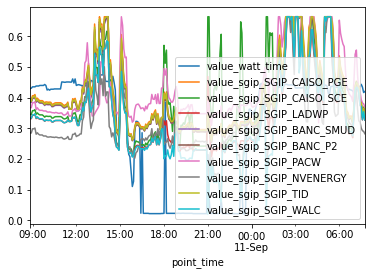

In [205]:
starttime = '2019-09-10T00:45:30-0800'
endtime = '2019-09-10T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
ax = df.plot()
ax.legend(bbox_to_anchor=(0.5, 1))

SGIP_CAISO_SDGE
SGIP_CAISO_PGE
SGIP_CAISO_SCE
SGIP_LADWP
SGIP_BANC_SMUD
SGIP_BANC_P2
SGIP_IID
SGIP_PACW
SGIP_NVENERGY
SGIP_TID
SGIP_WALC


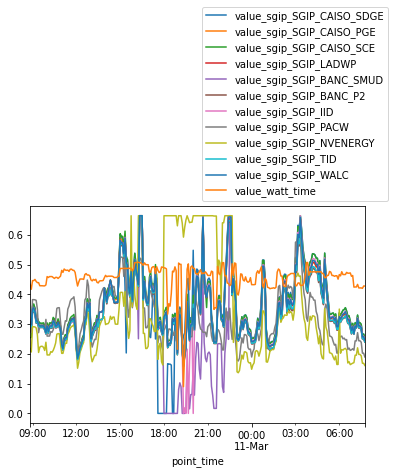

In [187]:
starttime = '2020-03-10T00:45:30-0800'
endtime = '2020-03-10T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
ax = df.plot()
ax.legend(bbox_to_anchor=(0.5, 1))

SGIP_CAISO_SDGE
SGIP_CAISO_PGE
SGIP_CAISO_SCE
SGIP_LADWP
SGIP_BANC_SMUD
SGIP_BANC_P2
SGIP_IID
SGIP_PACW
SGIP_NVENERGY
SGIP_TID
SGIP_WALC


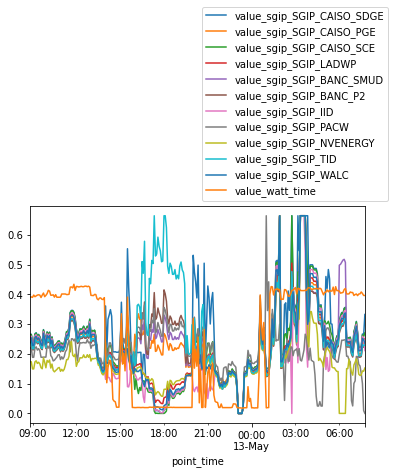

In [188]:
starttime = '2020-05-12T00:45:30-0800'
endtime = '2020-05-12T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
ax = df.plot()
ax.legend(bbox_to_anchor=(0.5, 1))